# Análise Exploratória do dataset vrawu1


In [1]:
# Bibliotecas
library(readr)
suppressMessages(library(dplyr))
library(DataExplorer)
library(stats)
library(ggplot2)
library(readxl)
library(tidyr)

In [2]:
# Carga dos dados
setwd("/home/jeff/github/DM2018/")
load("datasets/vrawu17.RData")
vrawu17[1:5,]

codigo_tipo_linha,cod_justificativa,icao_empresa,codigo_di,icao_destino,icao_origem,timekey_partida,voo,partida_prevista,partida_real,⋯,destino_descricao,destino_cidade,destino_uf,destino_pais,destino_continente,descricao_codigo_di,empresa,nacionalidade,descricao_justificativa,tipo_linha
,XN,LTG,0,SCDA,SBEG,201708131500,8484,2017-08-13 15:20:00,NA,⋯,DIEGO ARACENA INTERNATIONAL AIRPORT,IQUIQUE,NA,CHILE,AMERICA DO SUL,Vôo Regular,ABSA,BRASILEIRA,CANCELAMENTO POR MOTIVOS TÉCNICOS / OPERACIONAIS,NA
,XB,TPA,0,SBCT,KMIA,201708130900,843,2017-08-13 09:00:00,NA,⋯,AFONSO PENA,SÃO JOSÉ DOS PINHAIS,PR,BRASIL,AMERICA DO SUL,Vôo Regular,TAMPA S/A,ESTRANGEIRA,AUTORIZADO,NA
,NA,LTG,0,SVMI,SBEG,201708132100,8472,2017-08-13 21:42:00,2017-08-13 23:46:00,⋯,SIMON BOLIVAR INTERNATIONAL AIRPORT (MAIQUETIA INTERNATIONAL AIRPORT),CARACAS/INTL,NA,VENEZUELA,AMERICA DO SUL,Vôo Regular,ABSA,BRASILEIRA,NA,NA
,XN,LCO,0,SBKP,SBEG,201708140100,1509,2017-08-14 01:25:00,NA,⋯,VIRACOPOS,CAMPINAS,SP,BRASIL,AMERICA DO SUL,Vôo Regular,LAN CARGO S.A,ESTRANGEIRA,CANCELAMENTO POR MOTIVOS TÉCNICOS / OPERACIONAIS,NA
,XN,GLO,0,SBCT,SBPA,201708131300,1986,2017-08-13 13:02:00,NA,⋯,AFONSO PENA,SÃO JOSÉ DOS PINHAIS,PR,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,CANCELAMENTO POR MOTIVOS TÉCNICOS / OPERACIONAIS,NA


In [3]:
# Mantém apenas os vôos nacionais
vrawu17 <- vrawu17 %>% filter(origem_pais=="BRASIL"& destino_pais=="BRASIL")

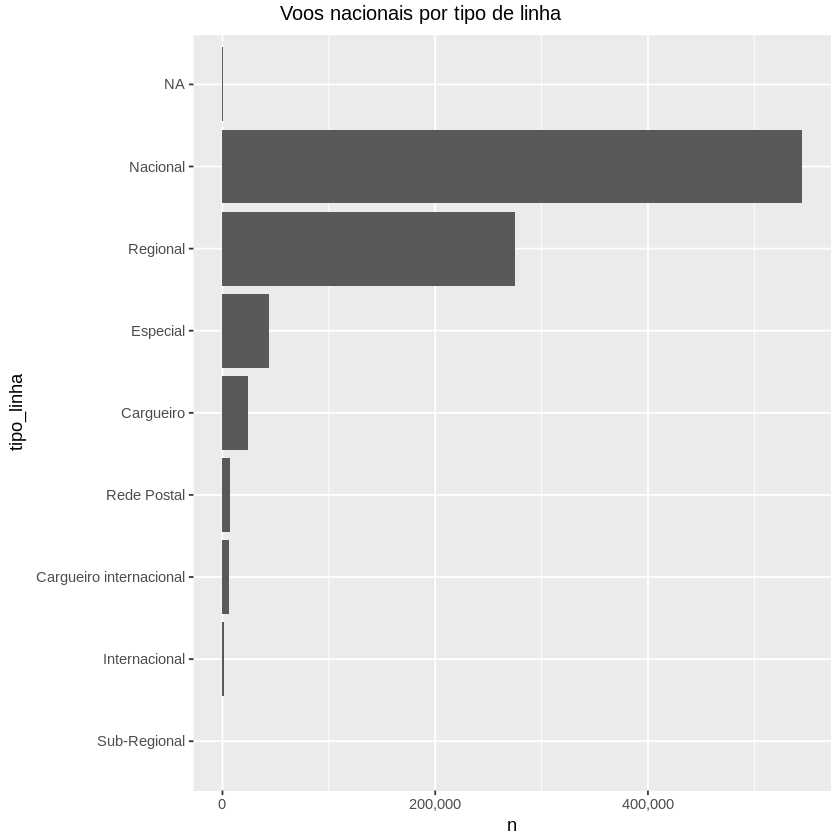

In [4]:
# Tipos de linhas
tipo_linha <- vrawu17 %>% count(tipo_linha)
plot_bar(tipo_linha, with = "n", title = "Voos nacionais por tipo de linha")

Obs.:
- Alguns voos nacionais estão classificados como internacionais (aparentemente, pernas de voos internacionais).
- Preferi analisar voos de todos os tipos

In [5]:
# Aeródromos
aerop = count(vrawu17, icao_origem)

São muitos aeródromos de pouca expressão. Vamos considerar apenas os que têm pelo menos 4 voos diários.

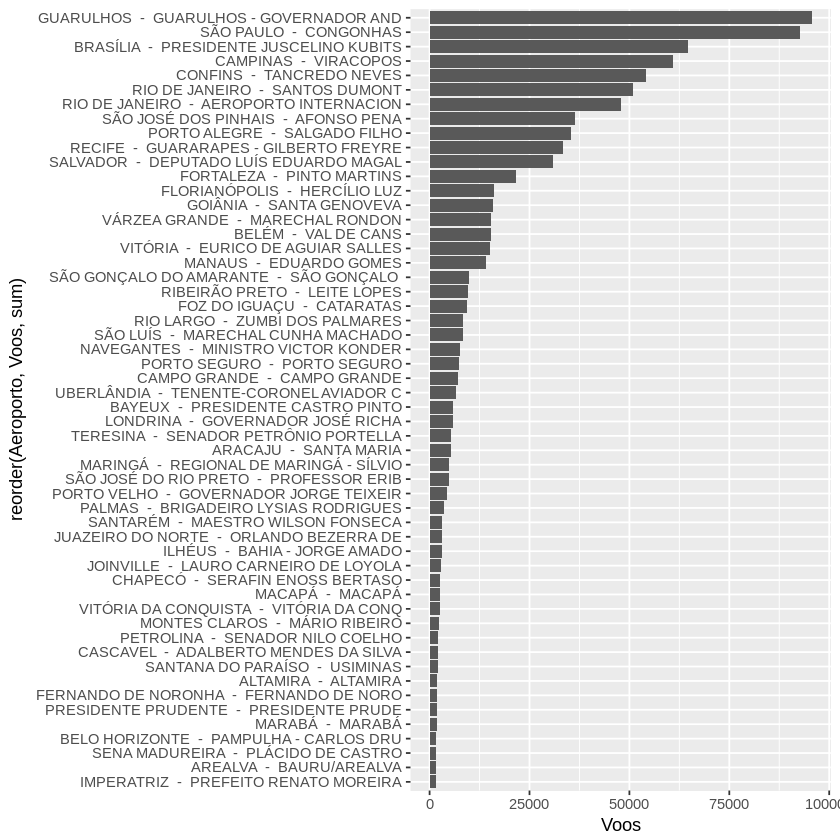

In [6]:
# Tabela temporaria com detalhes de aerportos
aerop = filter(aerop, n > 1460)
# Prepara rótulos mais apropriados para o gráfico
temp = select(vrawu17, icao_origem, origem_cidade, origem_descricao)
temp = unique(temp)
temp$aerop = substr(paste(temp$origem_cidade, " - ", temp$origem_descricao), 1, 40)
# Troca o código pelo nome 
aerop = merge(x = aerop, y = temp, all.x = TRUE)
aerop = select(aerop, icao_origem, aerop, n)
colnames(aerop) = c("Código", "Aeroporto", "Voos")
# Exibe o gráfico
ggplot(aerop, aes(x=reorder(Aeroporto,Voos,sum ) , y=Voos)) + geom_bar(show.legend = TRUE, stat = "identity") + coord_flip()
# (não foi possivel usar o Data Explorer pois há mais de 50 categorias na variável)
rm(temp)

In [7]:
# Filtrar o dataset
vrawu17 = vrawu17 %>% 
     filter(icao_origem %in% aerop$`Código`) %>%
     filter(icao_destino %in% aerop$`Código`)

Acrescentar a coluna que indica se houve algum atraso ou cancelamento devido a condições meteorológicas

In [8]:
# apenas os registros de cancelamento/atraso relacionados ao clima
# normativa IAC-1504
# http://www.anac.gov.br/assuntos/legislacao/legislacao-1/iac-e-is/iac/iac-1504/@@display-file/arquivo_norma/IAC1504.pdf
justificativas = select(vrawu17, cod_justificativa, descricao_justificativa)
justificativas = unique(justificativas)
justificativas = na.exclude(justificativas)
justmeteorologicas = filter(justificativas, cod_justificativa %in% c("WO", "WI", "WR", "WS", "WT", "WA", "XO", "XS", "XT", "AM", "RM"))

Cria a coluna target, contendo 1 para atrasos ou cancelamentos decorrentes do clima e 0 para outros casos.

In [9]:
# Cria coluna target, que identifica os atrasos ou cancelamentos provocados por eventos meteorológicos
target = ifelse(vrawu17$cod_justificativa %in% justmeteorologicas$cod_justificativa, 1, 0)
vrawu17 = cbind(vrawu17, target)

In [10]:
vrawu17[1:5,]

codigo_tipo_linha,cod_justificativa,icao_empresa,codigo_di,icao_destino,icao_origem,timekey_partida,voo,partida_prevista,partida_real,⋯,destino_cidade,destino_uf,destino_pais,destino_continente,descricao_codigo_di,empresa,nacionalidade,descricao_justificativa,tipo_linha,target
,XN,LCO,0,SBKP,SBEG,201708140100,1509,2017-08-14 01:25:00,NA,⋯,CAMPINAS,SP,BRASIL,AMERICA DO SUL,Vôo Regular,LAN CARGO S.A,ESTRANGEIRA,CANCELAMENTO POR MOTIVOS TÉCNICOS / OPERACIONAIS,NA,0
,XN,GLO,0,SBCT,SBPA,201708131300,1986,2017-08-13 13:02:00,NA,⋯,SÃO JOSÉ DOS PINHAIS,PR,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,CANCELAMENTO POR MOTIVOS TÉCNICOS / OPERACIONAIS,NA,0
,NA,GLO,0,SBSV,SBGL,201708132100,2034,2017-08-13 21:35:00,2017-08-13 21:35:00,⋯,SALVADOR,BA,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,NA,NA,0
,NA,GLO,0,SBGL,SBFZ,201708131200,2177,2017-08-13 12:57:00,2017-08-13 12:57:00,⋯,RIO DE JANEIRO,RJ,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,NA,NA,0
,NA,GLO,0,SBRF,SBSP,201708130600,1552,2017-08-13 06:00:00,2017-08-13 06:00:00,⋯,RECIFE,PE,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,NA,NA,0


In [11]:
# Cria coluna target_ori, que identifica os atrasos ou cancelamentos provocados por eventos meteorológicos no aeroporto de origem
justMeteorOrigem = filter(justificativas, cod_justificativa %in% c("WO", "XO"))
target_ori = ifelse(vrawu17$cod_justificativa %in% justMeteorOrigem$cod_justificativa, 1, 0)
vrawu17 = cbind(vrawu17, target_ori)

In [12]:
vrawu17[1:5,]

codigo_tipo_linha,cod_justificativa,icao_empresa,codigo_di,icao_destino,icao_origem,timekey_partida,voo,partida_prevista,partida_real,⋯,destino_uf,destino_pais,destino_continente,descricao_codigo_di,empresa,nacionalidade,descricao_justificativa,tipo_linha,target,target_ori
,XN,LCO,0,SBKP,SBEG,201708140100,1509,2017-08-14 01:25:00,NA,⋯,SP,BRASIL,AMERICA DO SUL,Vôo Regular,LAN CARGO S.A,ESTRANGEIRA,CANCELAMENTO POR MOTIVOS TÉCNICOS / OPERACIONAIS,NA,0,0
,XN,GLO,0,SBCT,SBPA,201708131300,1986,2017-08-13 13:02:00,NA,⋯,PR,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,CANCELAMENTO POR MOTIVOS TÉCNICOS / OPERACIONAIS,NA,0,0
,NA,GLO,0,SBSV,SBGL,201708132100,2034,2017-08-13 21:35:00,2017-08-13 21:35:00,⋯,BA,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,NA,NA,0,0
,NA,GLO,0,SBGL,SBFZ,201708131200,2177,2017-08-13 12:57:00,2017-08-13 12:57:00,⋯,RJ,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,NA,NA,0,0
,NA,GLO,0,SBRF,SBSP,201708130600,1552,2017-08-13 06:00:00,2017-08-13 06:00:00,⋯,PE,BRASIL,AMERICA DO SUL,Vôo Regular,GOL,BRASILEIRA,NA,NA,0,0


Quais aeroportos atrasam/cancelam mais voos devido a condções meteorológicas?

In [13]:
# Ordena os aeroportos por percentual de atrasos
ranking_aerop_atrasos  = 
  vrawu17 %>% 
    group_by(icao_origem) %>% 
    count(target_ori) %>% 
    spread(target_ori, n) %>% 
    mutate(perc = `1`/`0`)

In [14]:
# Recupera os nomes dos aeroportos e classifica
ranking_aerop_atrasos = merge(x=ranking_aerop_atrasos, y = aerop, by.x = "icao_origem", by.y = "Código", all.x = TRUE)
ranking_aerop_atrasos =ranking_aerop_atrasos %>% select(icao_origem, Aeroporto, `0`, `1`, Voos, perc) %>% arrange(desc(perc))

In [15]:
# Top 10 com mais atrasos/cancelamentos
ranking_aerop_atrasos[1:10,]

icao_origem,Aeroporto,0,1,Voos,perc
SBCA,CASCAVEL - ADALBERTO MENDES DA SILVA,2033,86,2119,"0,04230202"
SBCH,CHAPECÓ - SERAFIN ENOSS BERTASO,2562,76,2638,"0,02966432"
SBQV,VITÓRIA DA CONQUISTA - VITÓRIA DA CONQ,2531,72,2603,"0,02844725"
SBAE,AREALVA - BAURU/AREALVA,1238,25,1522,"0,02019386"
SBJV,JOINVILLE - LAURO CARNEIRO DE LOYOLA,2825,47,2872,"0,01663717"
SBIL,ILHÉUS - BAHIA - JORGE AMADO,3002,48,3050,"0,01598934"
SBMG,MARINGÁ - REGIONAL DE MARINGÁ - SÍLVIO,4803,67,4870,"0,01394961"
SBLO,LONDRINA - GOVERNADOR JOSÉ RICHA,5712,72,5784,"0,01260504"
SBFN,FERNANDO DE NORONHA - FERNANDO DE NORO,1887,22,1909,"0,01165872"
SBMQ,MACAPÁ - MACAPÁ,2603,30,2633,"0,01152516"


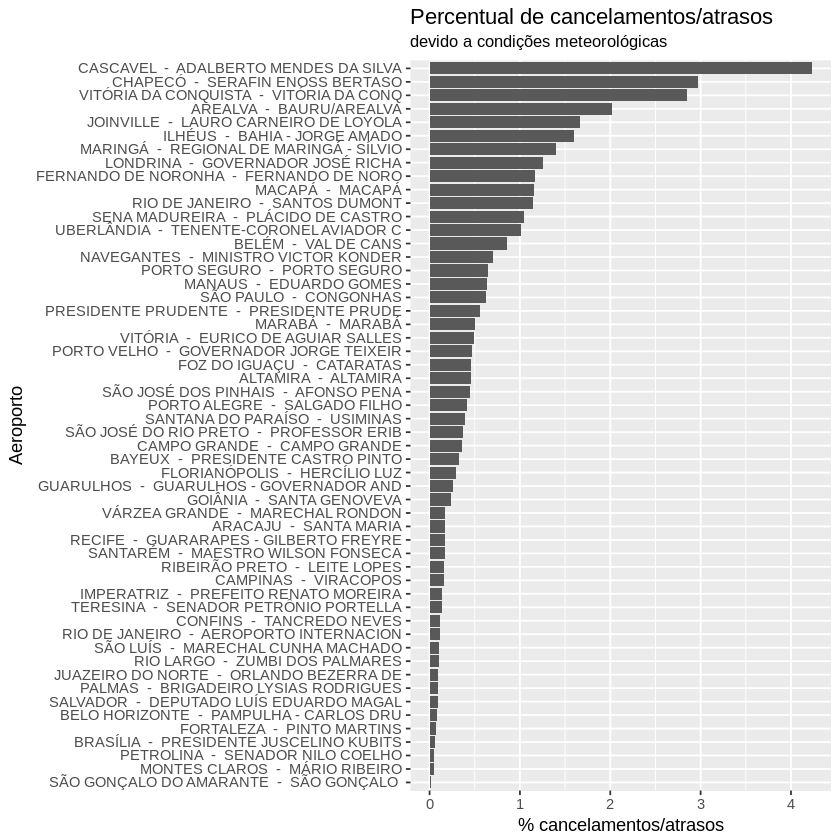

In [27]:
# Exibe o gráfico
# Exibe o gráfico
g = ggplot(ranking_aerop_atrasos, aes(x=reorder(Aeroporto,perc,sum ) , y=perc*100)) + 
    geom_bar(show.legend = TRUE, stat = "identity") +
    coord_flip()
g = g + ggtitle("Percentual de cancelamentos/atrasos", subtitle="devido a condições meteorológicas") +
        xlab("Aeroporto") +
        ylab("% cancelamentos/atrasos")
plot(g)

Análise de condições climáticas durante os eventos de atrasos/cancelamentos

In [30]:
# Top 50 com mais atrasos/cancelamentos
aerop_atrasos_top_50 = ranking_aerop_atrasos[1:10,1:2]
vrawu50 = vra

icao_origem,Aeroporto
SBCA,CASCAVEL - ADALBERTO MENDES DA SILVA
SBCH,CHAPECÓ - SERAFIN ENOSS BERTASO
SBQV,VITÓRIA DA CONQUISTA - VITÓRIA DA CONQ
SBAE,AREALVA - BAURU/AREALVA
SBJV,JOINVILLE - LAURO CARNEIRO DE LOYOLA
SBIL,ILHÉUS - BAHIA - JORGE AMADO
SBMG,MARINGÁ - REGIONAL DE MARINGÁ - SÍLVIO
SBLO,LONDRINA - GOVERNADOR JOSÉ RICHA
SBFN,FERNANDO DE NORONHA - FERNANDO DE NORO
SBMQ,MACAPÁ - MACAPÁ
